# Video style transfer

## Import libraries

In [2]:
import matplotlib.pyplot as plt 

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import utils
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('------------------------------------------------------------------')
print(torch.__version__,device)
print('------------------------------------------------------------------')

------------------------------------------------------------------
2.0.1+cu117 cuda
------------------------------------------------------------------


In [170]:
# Instant Style Transfer
class IST(nn.Module):
    def __init__(self):
        super(IST, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            # nn.InstanceNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            # nn.InstanceNorm2d(32),
            nn.ReLU(inplace=True),
            # nn.AvgPool2d(kernel_size=2, stride=2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=1, stride=1)
        )
        
    def forward(self, x):
        # Encoder path
        x1 = self.encoder(x)
        
        # Decoder path
        x2 = self.decoder(x1)
        # print(x.shape, x1.shape, x2.shape)
        return x2+x

/home/roliu/miniconda3/envs/VST/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/roliu/miniconda3/envs/VST/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/250 [00:00<?, ?it/s]

Total loss:  124.66109466552734
Content loss:  0.2177877277135849
Style loss:  120.30534362792969


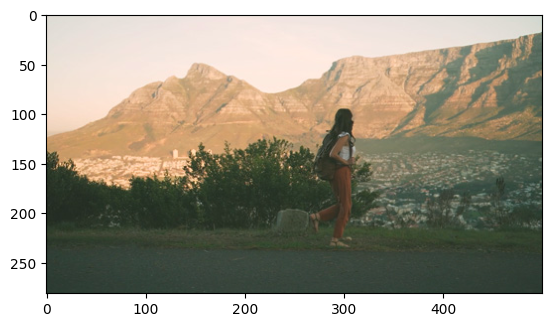

Total loss:  72.50162506103516
Content loss:  1.1943284273147583
Style loss:  48.61505889892578


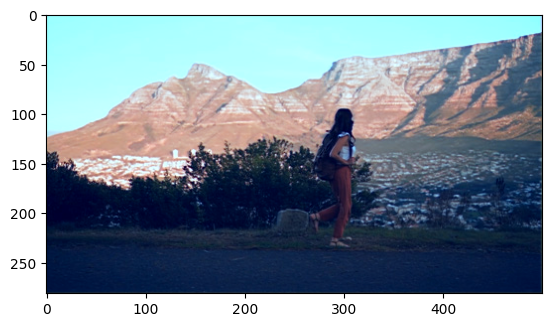

Total loss:  64.27079010009766
Content loss:  0.9788457155227661
Style loss:  44.69387435913086


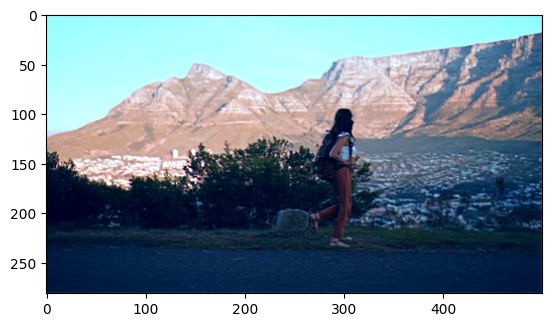

Total loss:  60.321685791015625
Content loss:  0.9421053528785706
Style loss:  41.47957992553711


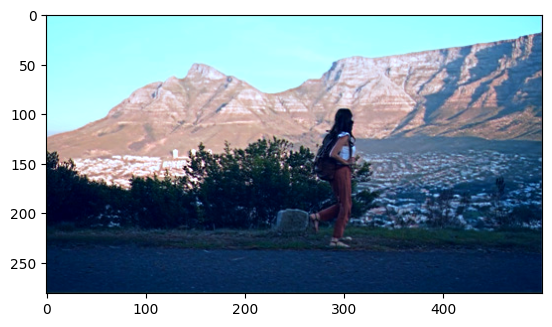

Total loss:  57.676910400390625
Content loss:  0.9390057921409607
Style loss:  38.896793365478516


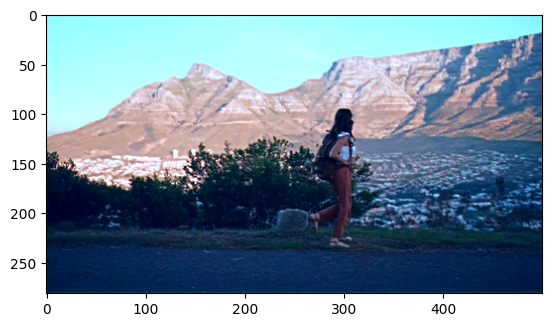

Total loss:  56.21399688720703
Content loss:  0.9033728837966919
Style loss:  38.14653778076172


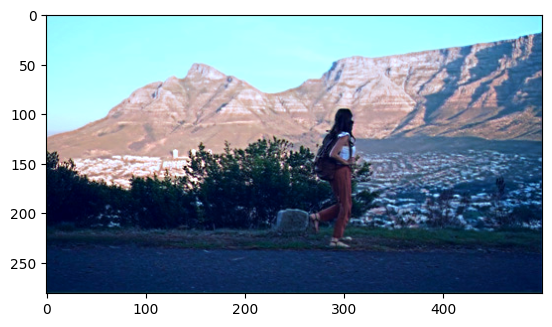

  0%|          | 0/250 [00:01<?, ?it/s]


In [173]:
VGG = models.vgg19(pretrained=True).features
VGG.to(device)
for parameter in VGG.parameters():
    parameter.requires_grad_(False)

style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}


content_weight = 20
style_weight = 1

dataset = './dataset/'
content_path = dataset+'input/'
style_path = dataset+'style/'
# content_path = './frames/'
# style_path = './styles/'
for i in tqdm(os.listdir(content_path)):

    torch.manual_seed(0)

    style_net = IST()
    style_net.to(device)

    optimizer = optim.Adam(style_net.parameters(), lr=0.001)

    input = utils.load_image(content_path+i)
    # content_image = transforms.functional.resize(input, (512,512))
    content_image = input.to(device)
    style_image = utils.load_image(style_path+'tar49.png')
    # style_image = transforms.functional.resize(style_image, (512,512))
    style_image = style_image.to(device)

    content_features = utils.get_features(content_image, VGG)
    style_features   = utils.get_features(style_image, VGG)

    style_gram_matrixs = {layer: utils.get_grim_matrix(style_features[layer]) for layer in style_features}

    for epoch in range(0, 100):

        target = style_net(content_image).to(device)
        target.requires_grad_(True)
        
        target_features = utils.get_features(target, VGG)  # extract output image's all feature maps
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
        
        style_loss = 0

        for layer in style_weights:
            
            target_feature = target_features[layer]  # output image's feature map after layer
            target_gram_matrix = utils.get_grim_matrix(target_feature)
            style_gram_matrix = style_gram_matrixs[layer]

            layer_style_loss = style_weights[layer] * torch.mean((target_gram_matrix - style_gram_matrix) ** 2)
            b, c, h, w = target_feature.shape
            style_loss = style_loss + layer_style_loss / (c * h * w)


        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if epoch % 20==0 or epoch ==99:
            # print("After %d criterions:" % epoch)
            print('Total loss: ', total_loss.item())
            print('Content loss: ', content_loss.item())
            print('Style loss: ', style_loss.item())
            plt.imshow(utils.im_convert(target))
            plt.show()
    break
    # print('Total loss: ', total_loss.item())
    # print('Content loss: ', content_loss.item())
    # print('Style loss: ', style_loss.item())
    # plt.imsave('outputs/'+i, utils.im_convert(target))
# 






## Load content and style images; Convert them into tensors running on the GPU 

## Train the HRNet model

## Display the comparision

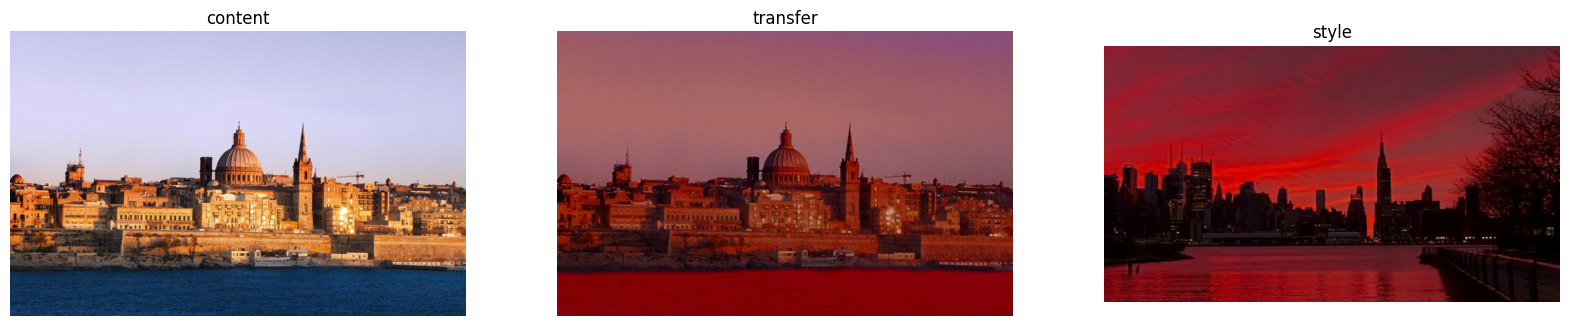

In [84]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

ax1.imshow(utils.im_convert(input))
ax1.set_title('content')
ax2.imshow(utils.im_convert(target))
ax2.set_title('transfer')
ax3.imshow(utils.im_convert(style_image))
ax3.set_title('style')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.show()

## Apply the model to all frames (If satisfied)

In [175]:
for i in tqdm(range(1, 251)):
  input = utils.load_image("./frames/"+str(i)+".jpg")
  content_image = input
  content_image = content_image.to(device)
  target = style_net(content_image).to(device)

  plt.imsave('outputs/'+str(i)+'.jpg',utils.im_convert(target))


100%|██████████| 250/250 [00:01<00:00, 149.00it/s]
